<a href="https://colab.research.google.com/github/RyosukeHanaoka/flask_deploy/blob/main/swin_transformer_tuning_with_mixup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 概要

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install vit-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 15.9 MB/s eta 0:00:00


In [3]:
!pip install vit_pytorch timm
from __future__ import print_function

import glob
import os
import random
import cv2
import shutil
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
from vit_pytorch.efficient import ViT
from pathlib import Path
import seaborn as sns
import timm
from pprint import pprint

def split_and_move_files(src_dir, train_dest, val_dest, test_dest, split_ratio=(0.6, 0.3, 0.1)):
    all_files = glob.glob(f"{src_dir}/*")
    random.shuffle(all_files)

    train_split = int(split_ratio[0] * len(all_files))
    val_split = train_split + int(split_ratio[1] * len(all_files))

    for idx, file in enumerate(all_files):
        if idx < train_split:
            dest = train_dest
        elif idx < val_split:
            dest = val_dest
        else:
            dest = test_dest
        os.makedirs(dest, exist_ok=True)
        shutil.copy(file, os.path.join(dest, os.path.basename(file)))

src_dir_RA = '/content/drive/MyDrive/images_ra_and_nonra/image_ra_patient'
train_dest_RA = '/content/train/RA_Right_Hand'
val_dest_RA = '/content/val/RA_Right_Hand'
test_dest_RA = '/content/test/RA_Right_Hand'

split_and_move_files(src_dir_RA, train_dest_RA, val_dest_RA, test_dest_RA)

src_dir_nonRA = '/content/drive/MyDrive/images_ra_and_nonra/image_nonra_patient'
train_dest_nonRA = '/content/train/nonRA_Right_Hand'
val_dest_nonRA = '/content/val/nonRA_Right_Hand'
test_dest_nonRA = '/content/test/nonRA_Right_Hand'

split_and_move_files(src_dir_nonRA, train_dest_nonRA, val_dest_nonRA, test_dest_nonRA)



In [4]:
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
from torch.optim import AdamW

In [11]:
batch_size=64
epochs = 50
lr = 0.5*3e-4
gamma = 0.8
seed = 42#乱数のシード。慣用的に42が使用されることが多い。
def seed_everything(seed):#使用するモジュールにおける乱数のシードを統一し、再現性を確保している。
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)#その他さまざまなtorchに含まれる非決定的な計算過程を決定的なものにして再現性を確保している
# GPUの設定
device = 'cuda'

from torchvision import transforms

# 前処理の定義
train_transforms = transforms.Compose([
    #transforms.Grayscale(num_output_channels=3), # グレースケール画像を3チャンネルに変換
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=15),
    # transforms.RandomVerticalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    #transforms.RandomHorizontalFlip(),
    # transforms.RandomGrayscale(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    #transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    #transforms.Grayscale(num_output_channels=3), # グレースケール画像を3チャンネルに変換
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    #transforms.Grayscale(num_output_channels=3), # グレースケール画像を3チャンネルに変換
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
from torchvision.datasets import ImageFolder
from PIL import Image, UnidentifiedImageError

# 画像のパス
train_dir = "/content/train"
val_dir = "/content/val"
test_dir = "/content/test"

class RobustImageFolder(ImageFolder):
    def __getitem__(self, index):
        try:
            return super(RobustImageFolder, self).__getitem__(index)
        except UnidentifiedImageError:
            print(f"Couldn't read image at index {index}: UnidentifiedImageError")
            # 代わりの画像を返す
            img = Image.new('RGB', (224, 224), color = 'gray')
            img = self.transform(img)
            target = 0  # または適切なクラスのインデックス
            return img, target

# データセットの定義
train_dataset = RobustImageFolder(train_dir, transform=train_transforms)
valid_dataset = RobustImageFolder(val_dir, transform=val_transforms)
test_dataset = RobustImageFolder(test_dir, transform=test_transforms)

# データローダーの設定を最適化
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,  # 実際のバッチサイズを小さくする
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2
)

valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True
)

model_names = timm.list_models(pretrained=True)
#pprint(model_names)
#model = timm.create_model('resnet50.tv_in1k', pretrained=True, num_classes=2)
#model = timm.create_model('vit_base_patch16_224_in21k', pretrained=True, num_classes=2)
#model = timm.create_model('swin_base_patch4_window7_224.ms_in1k', pretrained = True, num_classes=2)
model = timm.create_model(
    'swin_base_patch4_window7_224.ms_in1k',
    pretrained=True,
    num_classes=2,
    drop_block_rate=None,
    drop_connect_rate=None,
    drop_rate=0.4,          # 通常のドロップアウト
    attn_drop_rate=0.3,     # アテンション層のドロップアウト
    drop_path_rate=0.3      # Drop Path (Stochastic Depth) レート
)
# modelをGPUで動作させる
# Google Colabでランタイプ：GPUにしている場合は必要
model.to("cuda:0")
# loss function
#criterion = nn.CrossEntropyLoss()#正常と異常の２値分類であるためクロスエントロピー法を用いる。
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
# criterion = nn.HuberLoss()
# optimizer
#optimizer = optim.Adam(model.parameters(), lr=lr)#パラメーターはデフォルト値を使用する。学習率は上記に定めたものを使用
# オプティマイザーでの正則化も強化
optimizer = AdamW(  # Adamから正則化効果の高いAdamWに変更
    model.parameters(),
    lr=lr,        # 学習率を若干下げる
    weight_decay=1e-2  # 大幅に増加
)
# scheduler
#scheduler = StepLR(optimizer, step_size=3, gamma=gamma)
scheduler = CosineAnnealingLR(  # StepLRからCosineAnnealingLRに変更
    optimizer,
    T_max=50,
    eta_min=1e-6
)

学習ループを設定し、実行していく

In [12]:
import gc
from torchvision.utils import make_grid

# メモリ最適化の環境変数設定
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = ':'.join([
    'max_split_size_mb:128',
    'expandable_segments:True'
])

class Mixup:
    def __init__(self, alpha=0.2):
        self.alpha = alpha

    def __call__(self, batch, target):
        if self.alpha > 0:
            lam = np.random.beta(self.alpha, self.alpha)
        else:
            lam = 1

        batch_size = len(batch)
        index = torch.randperm(batch_size).to(batch.device)

        mixed_batch = lam * batch + (1 - lam) * batch[index, :]
        target_a, target_b = target, target[index]
        return mixed_batch, target_a, target_b, lam

def train_with_gradient_accumulation(model, train_loader, valid_loader, test_loader, criterion, optimizer, scheduler, device, epochs):
    accumulation_steps = 4
    effective_batch_size = batch_size
    actual_batch_size = effective_batch_size // accumulation_steps

    train_acc_list = []
    val_acc_list = []
    test_acc_list = []
    train_loss_list = []
    val_loss_list = []
    test_loss_list = []

    scaler = torch.cuda.amp.GradScaler()
    # Mixupインスタンスを作成
    mixup = Mixup(alpha=0.2)

    for epoch in range(epochs):
        # 訓練フェーズ
        model.train()
        epoch_loss = 0
        epoch_accuracy = 0
        optimizer.zero_grad()

        for i, (data, label) in enumerate(tqdm(train_loader)):
            with torch.cuda.amp.autocast():
                data = data.to(device)
                label = label.to(device)

                # Mixupの適用
                mixed_data, labels_a, labels_b, lam = mixup(data, label)

                output = model(mixed_data)
                # Mixup損失の計算
                loss = criterion(output, labels_a) * lam + criterion(output, labels_b) * (1 - lam)
                loss = loss / accumulation_steps

            scaler.scale(loss).backward()

            if ((i + 1) % accumulation_steps == 0) or (i + 1 == len(train_loader)):
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)

            # Mixupを考慮した精度計算
            acc = (lam * (output.argmax(dim=1) == labels_a).float() +
                  (1 - lam) * (output.argmax(dim=1) == labels_b).float()).mean()
            epoch_accuracy += acc / len(train_loader)
            epoch_loss += loss * accumulation_steps / len(train_loader)

            del data, label, mixed_data, labels_a, labels_b, output, loss
            if (i + 1) % (accumulation_steps * 2) == 0:
                torch.cuda.empty_cache()


        # 検証フェーズ
        model.eval()
        with torch.no_grad():
            epoch_val_accuracy = 0
            epoch_val_loss = 0
            for data, label in valid_loader:
                data = data.to(device)
                label = label.to(device)

                val_output = model(data)
                val_loss = criterion(val_output, label)

                acc = (val_output.argmax(dim=1) == label).float().mean()
                epoch_val_accuracy += acc / len(valid_loader)
                epoch_val_loss += val_loss / len(valid_loader)

                del data, label, val_output, val_loss

            # テストフェーズ
            epoch_test_accuracy = 0
            epoch_test_loss = 0
            for data, label in tqdm(test_loader):
                data = data.to(device)
                label = label.to(device)

                test_output = model(data)
                test_loss = criterion(test_output, label)

                acc = (test_output.argmax(dim=1) == label).float().mean()
                epoch_test_accuracy += acc / len(test_loader)
                epoch_test_loss += test_loss / len(test_loader)

                del data, label, test_output, test_loss

            torch.cuda.empty_cache()

        # 結果の記録
        train_acc_list.append(epoch_accuracy)
        val_acc_list.append(epoch_val_accuracy)
        test_acc_list.append(epoch_test_accuracy)
        train_loss_list.append(epoch_loss)
        val_loss_list.append(epoch_val_loss)
        test_loss_list.append(epoch_test_loss)

        print(
            f"Epoch : {epoch+1} - "
            f"loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - "
            f"val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f} - "
            f"test_loss : {epoch_test_loss:.4f} - test_acc: {epoch_test_accuracy:.4f}\n"
        )

        scheduler.step()

    return train_acc_list, val_acc_list, test_acc_list, train_loss_list, val_loss_list, test_loss_list
# モデルの設定を最適化
def optimize_model_settings():
    # メモリ関連の設定を最適化
    torch.backends.cudnn.benchmark = True
    torch.backends.cuda.matmul.allow_tf32 = True

    # モデルの設定を最適化
    model.to(device)
    if hasattr(model, 'transformer'):
        for block in model.transformer.blocks:
            block.attn.fused_attn = True

    return model
# main関数も更新
def main():
    model = optimize_model_settings()
    train_acc_list, val_acc_list, test_acc_list, train_loss_list, val_loss_list, test_loss_list = train_with_gradient_accumulation(
        model, train_loader, valid_loader, test_loader, criterion, optimizer, scheduler, device, epochs
    )
    return model, train_acc_list, val_acc_list, test_acc_list, train_loss_list, val_loss_list, test_loss_list

# 実行
model, train_acc_list, val_acc_list, test_acc_list, train_loss_list, val_loss_list, test_loss_list = main()

<ipython-input-12-add7156f71cd>:40: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


  0%|          | 0/4 [00:00<?, ?it/s]

<ipython-input-12-add7156f71cd>:52: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.7160 - acc: 0.5793 - val_loss : 0.9108 - val_acc: 0.4453 - test_loss : 0.8261 - test_acc: 0.5385



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.6970 - acc: 0.5608 - val_loss : 0.6404 - val_acc: 0.5963 - test_loss : 0.6464 - test_acc: 0.6410



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.7625 - acc: 0.4661 - val_loss : 0.9212 - val_acc: 0.4453 - test_loss : 0.8606 - test_acc: 0.5385



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.9215 - acc: 0.5258 - val_loss : 0.6457 - val_acc: 0.6157 - test_loss : 0.6447 - test_acc: 0.6410



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.6638 - acc: 0.6353 - val_loss : 0.6307 - val_acc: 0.8209 - test_loss : 0.6459 - test_acc: 0.6923



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.6897 - acc: 0.5428 - val_loss : 0.6306 - val_acc: 0.7164 - test_loss : 0.6394 - test_acc: 0.6667



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.6551 - acc: 0.6250 - val_loss : 0.6279 - val_acc: 0.6739 - test_loss : 0.6364 - test_acc: 0.6154



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.6331 - acc: 0.6528 - val_loss : 0.6067 - val_acc: 0.7358 - test_loss : 0.6250 - test_acc: 0.6667



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.6495 - acc: 0.6437 - val_loss : 0.5674 - val_acc: 0.8365 - test_loss : 0.6066 - test_acc: 0.6667



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.6267 - acc: 0.6487 - val_loss : 0.5579 - val_acc: 0.7978 - test_loss : 0.6044 - test_acc: 0.6923



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.6110 - acc: 0.6852 - val_loss : 0.6053 - val_acc: 0.6661 - test_loss : 0.6402 - test_acc: 0.6154



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.6104 - acc: 0.6713 - val_loss : 0.5368 - val_acc: 0.7629 - test_loss : 0.5998 - test_acc: 0.6923



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.5346 - acc: 0.7932 - val_loss : 0.5046 - val_acc: 0.8016 - test_loss : 0.5873 - test_acc: 0.6923



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.5617 - acc: 0.7586 - val_loss : 0.5811 - val_acc: 0.7088 - test_loss : 0.6420 - test_acc: 0.6923



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.6050 - acc: 0.7439 - val_loss : 0.5223 - val_acc: 0.7513 - test_loss : 0.6045 - test_acc: 0.6667



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.5097 - acc: 0.8058 - val_loss : 0.4767 - val_acc: 0.8287 - test_loss : 0.5838 - test_acc: 0.7436



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.5738 - acc: 0.7554 - val_loss : 0.5118 - val_acc: 0.7551 - test_loss : 0.6006 - test_acc: 0.6667



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.5128 - acc: 0.7837 - val_loss : 0.5510 - val_acc: 0.7048 - test_loss : 0.6284 - test_acc: 0.6410



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.5387 - acc: 0.7588 - val_loss : 0.5207 - val_acc: 0.7513 - test_loss : 0.6051 - test_acc: 0.6667



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.5159 - acc: 0.7639 - val_loss : 0.4897 - val_acc: 0.8054 - test_loss : 0.5834 - test_acc: 0.7692



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 21 - loss : 0.5217 - acc: 0.7885 - val_loss : 0.4891 - val_acc: 0.8054 - test_loss : 0.5834 - test_acc: 0.7692



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 22 - loss : 0.4978 - acc: 0.7946 - val_loss : 0.5088 - val_acc: 0.7589 - test_loss : 0.6015 - test_acc: 0.6923



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 23 - loss : 0.5285 - acc: 0.7818 - val_loss : 0.5327 - val_acc: 0.7396 - test_loss : 0.6242 - test_acc: 0.6410



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 24 - loss : 0.5792 - acc: 0.7415 - val_loss : 0.5445 - val_acc: 0.7280 - test_loss : 0.6338 - test_acc: 0.6410



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 25 - loss : 0.4587 - acc: 0.8346 - val_loss : 0.5149 - val_acc: 0.7667 - test_loss : 0.6094 - test_acc: 0.6410



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 26 - loss : 0.4898 - acc: 0.7981 - val_loss : 0.4888 - val_acc: 0.8054 - test_loss : 0.5885 - test_acc: 0.7692



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 27 - loss : 0.5319 - acc: 0.7802 - val_loss : 0.4823 - val_acc: 0.8170 - test_loss : 0.5844 - test_acc: 0.7692



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 28 - loss : 0.5232 - acc: 0.7936 - val_loss : 0.5065 - val_acc: 0.7589 - test_loss : 0.6013 - test_acc: 0.7179



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 29 - loss : 0.4651 - acc: 0.8301 - val_loss : 0.5222 - val_acc: 0.7551 - test_loss : 0.6111 - test_acc: 0.6410



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 30 - loss : 0.5023 - acc: 0.8023 - val_loss : 0.5061 - val_acc: 0.7589 - test_loss : 0.5948 - test_acc: 0.7179



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 31 - loss : 0.4514 - acc: 0.8393 - val_loss : 0.4821 - val_acc: 0.8016 - test_loss : 0.5754 - test_acc: 0.7436



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 32 - loss : 0.6095 - acc: 0.6810 - val_loss : 0.4743 - val_acc: 0.8132 - test_loss : 0.5683 - test_acc: 0.7949



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 33 - loss : 0.5449 - acc: 0.7495 - val_loss : 0.4832 - val_acc: 0.7900 - test_loss : 0.5727 - test_acc: 0.7436



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 34 - loss : 0.5324 - acc: 0.7900 - val_loss : 0.4859 - val_acc: 0.7705 - test_loss : 0.5724 - test_acc: 0.7436



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 35 - loss : 0.4643 - acc: 0.8251 - val_loss : 0.4861 - val_acc: 0.7705 - test_loss : 0.5724 - test_acc: 0.7436



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 36 - loss : 0.5084 - acc: 0.7750 - val_loss : 0.4770 - val_acc: 0.8132 - test_loss : 0.5666 - test_acc: 0.7692



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 37 - loss : 0.5113 - acc: 0.7789 - val_loss : 0.4743 - val_acc: 0.8132 - test_loss : 0.5648 - test_acc: 0.7949



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 38 - loss : 0.4652 - acc: 0.8151 - val_loss : 0.4740 - val_acc: 0.8132 - test_loss : 0.5652 - test_acc: 0.7949



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 39 - loss : 0.4661 - acc: 0.8278 - val_loss : 0.4722 - val_acc: 0.8132 - test_loss : 0.5651 - test_acc: 0.7949



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 40 - loss : 0.5390 - acc: 0.7801 - val_loss : 0.4698 - val_acc: 0.8132 - test_loss : 0.5638 - test_acc: 0.7949



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 41 - loss : 0.4386 - acc: 0.8654 - val_loss : 0.4695 - val_acc: 0.8132 - test_loss : 0.5641 - test_acc: 0.7949



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 42 - loss : 0.4158 - acc: 0.8713 - val_loss : 0.4701 - val_acc: 0.8132 - test_loss : 0.5656 - test_acc: 0.7949



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 43 - loss : 0.4875 - acc: 0.8116 - val_loss : 0.4713 - val_acc: 0.8132 - test_loss : 0.5668 - test_acc: 0.7949



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 44 - loss : 0.4329 - acc: 0.8536 - val_loss : 0.4723 - val_acc: 0.8132 - test_loss : 0.5681 - test_acc: 0.7949



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 45 - loss : 0.4565 - acc: 0.8323 - val_loss : 0.4731 - val_acc: 0.8132 - test_loss : 0.5692 - test_acc: 0.7949



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 46 - loss : 0.5045 - acc: 0.7837 - val_loss : 0.4734 - val_acc: 0.8132 - test_loss : 0.5697 - test_acc: 0.7949



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 47 - loss : 0.4753 - acc: 0.7970 - val_loss : 0.4729 - val_acc: 0.8132 - test_loss : 0.5696 - test_acc: 0.7949



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 48 - loss : 0.4306 - acc: 0.8507 - val_loss : 0.4725 - val_acc: 0.8132 - test_loss : 0.5695 - test_acc: 0.7949



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 49 - loss : 0.4373 - acc: 0.8347 - val_loss : 0.4728 - val_acc: 0.8132 - test_loss : 0.5698 - test_acc: 0.7949



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 50 - loss : 0.5124 - acc: 0.7719 - val_loss : 0.4732 - val_acc: 0.8132 - test_loss : 0.5701 - test_acc: 0.7949



# 学習結果の可視化

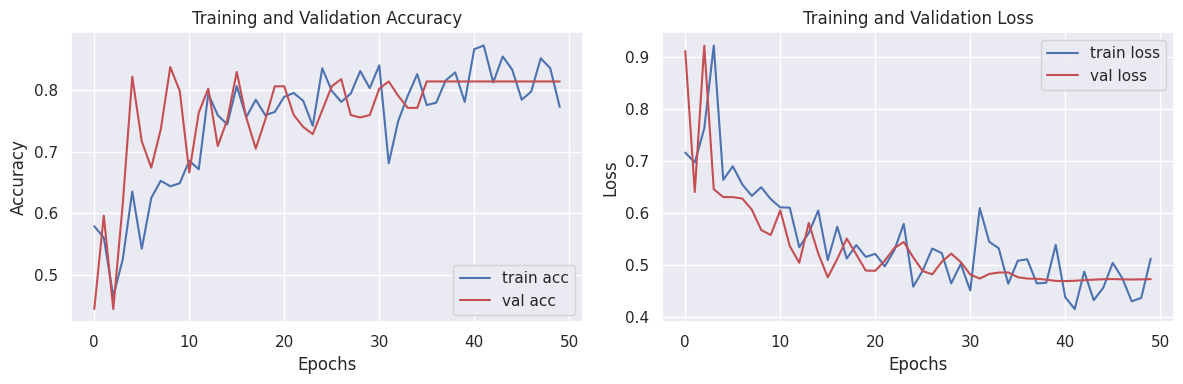

In [13]:
#出力したテンソルのデバイスをCPUへ切り替える
# GoogleColabの場合は不要
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 仮にepochsの数をトレーニングデータの長さから取得する
epochs = len(train_acc_list)  # train_acc_listの長さを使用

train_acc = []
train_loss = []
val_acc = []
val_loss = []

# 各リストをnumpy配列に変換し、リストに追加
for i in range(epochs):
    train_acc.append(train_acc_list[i].detach().cpu().numpy())
    train_loss.append(train_loss_list[i].detach().cpu().numpy())
    val_acc.append(val_acc_list[i].detach().cpu().numpy())
    val_loss.append(val_loss_list[i].detach().cpu().numpy())

# グラフ化
sns.set()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(range(epochs), train_acc, 'b', label='train acc')
ax1.plot(range(epochs), val_acc, 'r', label='val acc')
ax1.set_title('Training and Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(range(epochs), train_loss, 'b', label='train loss')
ax2.plot(range(epochs), val_loss, 'r', label='val loss')
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()


In [ ]:
model_save_path = '/content/drive/MyDrive/vitcrp0.3_checkpoint'
torch.save(model.state_dict(), model_save_path)

NameError: name 'torch' is not defined

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV

def extract_logits(model, loader, device):
    model.eval()
    logits = []
    targets = []
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            logits.extend(output.cpu().numpy())
            targets.extend(target.cpu().numpy())
    return np.array(logits), np.array(targets)

# ロジットとターゲットを抽出
val_logits, val_targets = extract_logits(model, valid_loader, device)

# プラットスケーリングを使用してモデルをカリブレーション
calibrator = LogisticRegression(solver='liblinear', max_iter=1000)
calibrated_model = CalibratedClassifierCV(calibrator, method='sigmoid', cv='prefit')

# 検証セットのロジットとターゲットを使って、ベースのcalibratorをフィッティング
calibrator.fit(val_logits, val_targets)
# 検証セットの確率を使ってフィッティング
calibrated_model.fit(val_logits, val_targets)

# カリブレーション後の確率を評価
calibrated_probs = calibrated_model.predict_proba(val_logits)[:, 1]

# パフォーマンス評価
roc_auc = roc_auc_score(val_targets, calibrated_probs)
print(f"Calibrated ROC AUC: {roc_auc:.4f}")

# 保存や他の用途で使用するためにモデルを更新
model.calibrator = calibrated_model

Calibrated ROC AUC: 0.8235


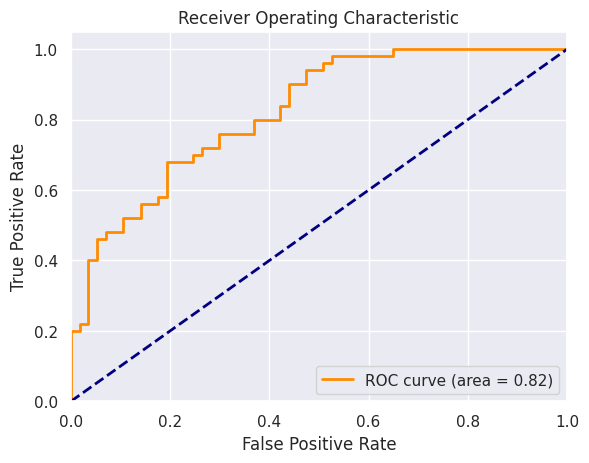

In [ ]:
from sklearn.metrics import roc_curve, auc
def plot_roc_curve(model, loader, device):
    # 真のラベルと予測確率を収集
    true_labels = []
    pred_probs = []

    model.eval()
    with torch.no_grad():
        for data, labels in loader:
            data = data.to(device)
            labels = labels.to(device)
            outputs = model(data)
            # ソフトマックスを適用して確率を取得
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            pred_probs.extend(probabilities[:, 1].cpu().numpy())  # クラス1の確率を取得
            true_labels.extend(labels.cpu().numpy())

    # ROCカーブの計算
    fpr, tpr, thresholds = roc_curve(true_labels, pred_probs)
    roc_auc = auc(fpr, tpr)

    # ROCカーブの描画
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# 使用例: 有効データローダーとデバイス情報を指定してROC曲線を描画
plot_roc_curve(model, valid_loader, device)


In [ ]:
import pickle
# カリブレーターの保存
with open('calibrated_model.pkl', 'wb') as f:
    pickle.dump(calibrated_model, f)

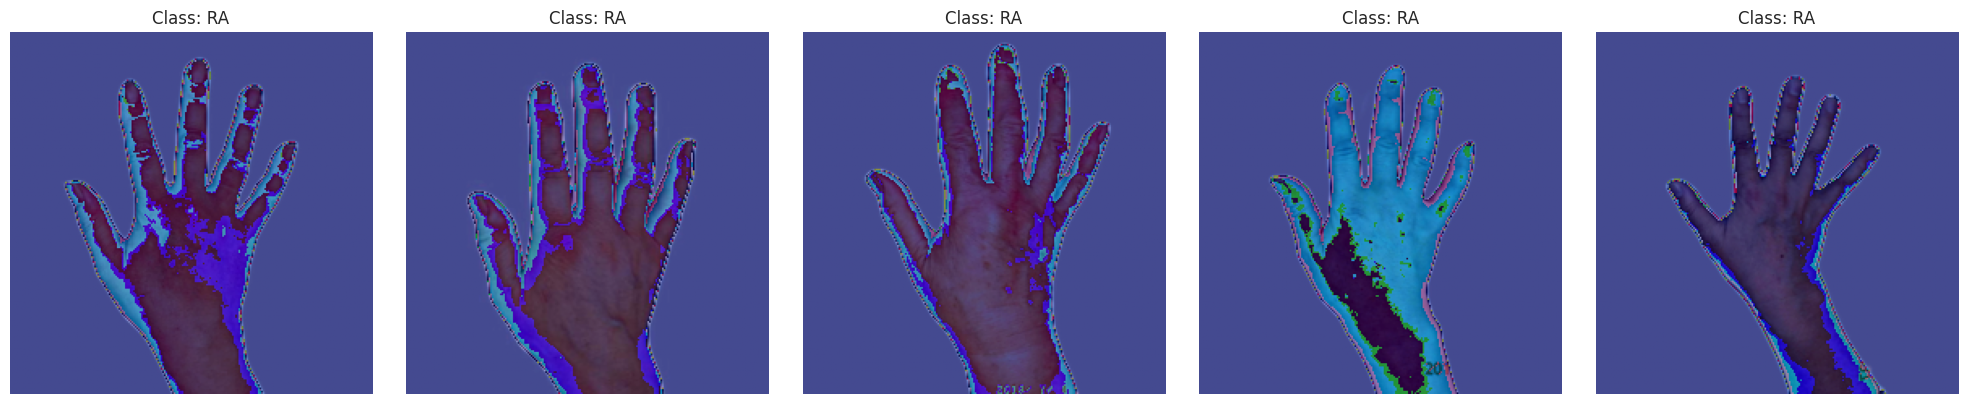

16730

In [ ]:
class GradCam:
    def __init__(self, model, device):
        self.model = model
        self.feature = None
        self.gradient = None
        self.device = device

        def forward_hook(module, input, output):
            self.feature = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradient = grad_out[0].detach()

        # Swin Transformerの最後のブロックを取得
        if hasattr(model, 'layers'):
            target_layer = model.layers[-1].blocks[-1]
            target_layer.register_forward_hook(forward_hook)
            target_layer.register_full_backward_hook(backward_hook)
        else:
            raise ValueError("Unexpected model architecture")

    def __call__(self, x):
        self.feature = None
        self.gradient = None

        x = x.to(self.device)

        output = self.model(x)
        pred_class = output.argmax(dim=1)

        self.model.zero_grad()
        one_hot = torch.zeros_like(output)
        one_hot[0, pred_class] = 1
        output.backward(gradient=one_hot)

        # Swin Transformerの特徴量マップの形状に合わせて処理
        feature_map = self.feature
        gradient_map = self.gradient

        # 重みの計算
        weights = gradient_map.mean(dim=(2, 3))  # Swinの場合、spatial dimensionsで平均を取る

        # CAMの計算
        batch_size = feature_map.shape[0]
        height = feature_map.shape[2]
        width = feature_map.shape[3]

        cam = torch.mul(feature_map, weights.view(batch_size, -1, 1, 1))
        cam = cam.sum(dim=1)  # チャネル方向に集約

        # 正規化とReLU
        cam = F.relu(cam)
        cam = cam.squeeze().cpu().numpy()

        # 元の画像サイズにリサイズ
        cam = cv2.resize(cam, (224, 224))
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-7)

        return cam

def overlay_heatmap_to_image(image, heatmap):
    image = ((image.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5) * 255).astype(np.uint8)

    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

    alpha = 0.4
    overlayed = cv2.addWeighted(image, 1 - alpha, heatmap_colored, alpha, 0)

    return overlayed / 255.0

# 実行部分
grad_cam = GradCam(model, device)

images, labels = next(iter(test_loader))
images = images[:5]
labels = labels[:5]

plt.figure(figsize=(20, 4))

for i, (image, label) in enumerate(zip(images, labels)):
    try:
        heatmap = grad_cam(image.unsqueeze(0))
        overlayed = overlay_heatmap_to_image(image, heatmap)

        plt.subplot(1, 5, i+1)
        plt.imshow(overlayed)
        plt.title(f'Class: {"RA" if label.item() == 0 else "Non-RA"}')
        plt.axis('off')
    except Exception as e:
        print(f"Error processing image {i}: {str(e)}")

plt.tight_layout()
plt.show()

torch.cuda.empty_cache()
gc.collect()